# Section 2. Sentiment Analysis

## 1. Logistic Regression review
Start with some feature vector x.
- $w^T x = 0$ (the line itself... this is the hyperplane that splits the classes!!!)
- $w^T x > 0$ (assign to a positive class)
- $w^T x < 0$ (assign to a negative class)

$\sum_{d=1}^{D} w_dx_d = w^T x$ 

- This is pretty much the same as a single neuron, as each input gets multiplied by its corresponding weight, and the resulting products get added together!

### Sigmoid function
With a logisitc regression, we pass the output of the $w^T x$ into the sigmoid funciton to get an output between 0 and 1.

$\sigma(x)=\frac{1}{1+exp^{-x}}$

The probability that y is 1 (binary class) given x inputs is equal to the dot product of weights and inputs passed through the sigmoid funciton:

$p(y=1|x) = \sigma(w^T x)$

Sigmoid turns aboslute numbers into probabilities between 0 and 1:

$w^T x > 0 \rightarrow \sigma(w^T x) > 0.5$

$w^T x < 0 \rightarrow \sigma(w^T x) < 0.5$ 

### Examples

#### Example 1

- x = [1,1], w = [2,0]
- x.dot(w) = 2
- sigmoid(x.dot(w)) = 0.88
- 88% certain that this is a class 1

*Note that the output is unaffected by the second component of x. This is because a weight of 0 tells you the corresponding input feature has NO predictive ability.*

#### Example 2

- x = [1,1], w = [0.5,0]
- x.dot(w) = 0.5
- sigmoid(x.dot(w)) = 0.62
- 62% certain this is a class 1

*Larger magnitude weights correspond to more important features in terms of predictive abilitiy.*

#### Example 3

- x = [1,1], w = [0.5,-1]
- x.dot(w) = -0.5
- sigmoid(x.dot(w)) = 0.38
- 62% certain this is a class 1

*Larger negative weight has more influence on the output.*

## 2. Tokenization

- This is not just using .split(" ").
- Have to deal with contractions (Don't = do not)
- Extra punctuation and symbols
- most of what you need to do can be done with nltk.tokenize.word_tokenize

### Custom tokenizer
- sometimes we want to write out own tokenizer
- remove stopwords like 'the', 'a', 'it'
- remove number and single letter tokens
- can be application specific (specific to your dataset)

## 3. Tokens to Vectors
- you could use sklearn
- however we will be using our own method!!!

**Binary bag of words:**
- if a word appears in a sentence, then that word gets a 1 in the feature vector
- otherwise 0
- doesnt matter how many times the word appears - appearing at least once gets you the same result
- since all feature vectors must be the same size, *AND they need to be able to represent every sentence in our dataset*, then the size of the feature vector must equal size of vocabulary... **ie n features must equal number of unique words in ALL instances**
- V is usually used to represent size of vocab

**The Bag of Words Feature Vector:**
- We need to know which words to map to which location in th vector
- For this we have a dictionary or map:
    - Key: word
    - value: a unique integer from 0 to V-1 (this tells us the index location in the vector)
    
**Problem with COUNT bag of words (term frequency):**
- For sentiment analysis, you generally want to use RAW COUNTS isntead
- However the problem with using counts is that really long sentences become REALLY long arrows (in the vector space).
- In other words, longer sentences (with more words) will skew the data
- So, what you want to do instead is **NORMALIZE each count vector by the total # of words in each document, which turns each element in the vector to a proportion**
- **THIS IS SUPER IMPORTANT FOR LOGISTIC REGRESSION (OR REALLY ANY ML TASK)**, MAINLY BECAUSE SIGMOID APPROACHES 1 VERRRRY QUICKLY (ANYTHING 10 OR ABOVE WILL BE SUPER CLOSE TO 1).... SO YOU GOTTA NORMALIZE!

### As we can see below, everything above 2.5 or below -2.5 is squeezed closed to abs(1)... sooo you gotta normalize when doing a logistic regression! This goes true for most ML tasks. 

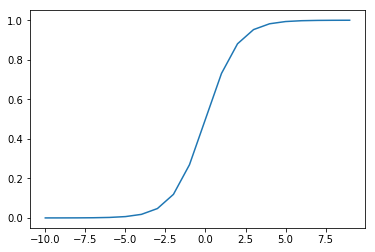

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
x = np.array(range(-10, 10))

def sigmoid(x):
    return 1 / (1+np.exp(-x))
sigmoid(x)

plt.plot(x,sigmoid(x))
plt.show()

## 4. Building a Sentiment Analyzer

### Load Data

In [3]:
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup

#this turns words like Cat's into cat.
wordnet_lemmatizer = WordNetLemmatizer()

# from http://www.lextek.com/manuals/onix/stopwords1.html
# this is a premade list of usual stopwords
# these typically have low predictive value...
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

# you could also use NLTK stop words source as follows:
#from nltk.corpus import stopwords
#stopwords.words('enlgish')

# load the reviews
# data courtesy of http://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html
positive_reviews = BeautifulSoup(open('positive.review').read(),'lxml')
positive_reviews = positive_reviews.findAll('review_text')

negative_reviews = BeautifulSoup(open('negative.review').read(), 'lxml')
negative_reviews = negative_reviews.findAll('review_text')

print(positive_reviews[0])
len(positive_reviews)

FileNotFoundError: [Errno 2] No such file or directory: 'stopwords.txt'

In [4]:
negative_reviews

NameError: name 'negative_reviews' is not defined

In [11]:
#lets quickly test out dat lemmatizer
words = ["dogs", "dog's", "can't", "churches"]
[wordnet_lemmatizer.lemmatize(word) for word in words]

#hmmm, doesnt seem to be dealing with apostraphes very well!
#we will have to look into this later

['dog', "dog's", "can't", 'church']

In [ ]:
sentences = ["hey my a"]

### Adjust for class imbalance

##### Note: the site appears to have updated the data, and there are no more class imbalances! So dont run the code below...
    #Option 1: take a random sample so we have balanced classes
    np.random.shuffle(positive_reviews)
    positive_reviews = positive_reviews[:len(negative_reviews)]

    #Option 2: Oversample the negative reviews
    diff = len(positive_reviews) - len(negative_reviews)
    idxs = np.random.choice(len(negative_reviews), size=diff)
    extra = [negative_reviews[i] for i in idxs]
    negative_reviews += extra

### Tokenize

First we will trey to use NLTKs tokenizer. However you will notice that is doesnt downcase so 'It' != 'it'. Thats not good! 

Also you really don't even want to include the word 'it'... its a stop word, and not of much use to us. It would probably only add noise to the model! Soooo after we use NLTK we will build are own tokenize function!

In [12]:
#tokenize with NLTK
#notice how it keeps "it" and "IT"
t = positive_reviews[0].text
set(nltk.tokenize.word_tokenize(t)) 

{',',
 '.',
 '2',
 '5',
 '<',
 'Amazon',
 'As',
 'Equally',
 'I',
 'It',
 'LCD',
 'PC',
 'This',
 'a',
 'always',
 'an',
 'and',
 'are',
 'area',
 'bad',
 'blackouts',
 'business',
 'cable',
 'clean',
 'compared',
 'data',
 'days',
 'down',
 'due',
 'electronics',
 'enough',
 'equipment',
 'failure',
 'feel',
 'for',
 'frequent',
 'going',
 'had',
 'important',
 'in',
 'investment',
 'irregular',
 'is',
 'it',
 'know',
 'loss',
 'me',
 'minor',
 'minutes',
 'modem',
 'monitor',
 'more',
 'my',
 'of',
 'or',
 'power',
 'purchased',
 'receiving',
 'router',
 'run',
 'save',
 'shut',
 'spike',
 'supplies',
 'supply',
 'than',
 'that',
 'the',
 'this',
 'time',
 'to',
 'unit',
 'valuable',
 'will',
 'work'}

In [14]:
#lets create a custom tokenize funciton (leveraging nltk)
def mikes_tokenizer(s):
    s = s.lower() #downcase
    tokens = nltk.tokenize.word_tokenize(s) #split s into word tokens
    tokens = [t for t in tokens if len(t)>2] #remove short words as they probably have low predictive quality
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] #puts words (like contractions) into base form
    tokens = [t for t in tokens if t not in stopwords] #get rid of dem stopwords yo!
    return tokens

mikes_tokenizer(t)

['purchased',
 'this',
 'unit',
 'due',
 'frequent',
 'blackout',
 'power',
 'supply',
 'bad',
 'run',
 'cable',
 'modem',
 'router',
 'lcd',
 'monitor',
 'minute',
 'this',
 'time',
 'save',
 'shut',
 'equally',
 'electronics',
 'receiving',
 'clean',
 'power',
 'feel',
 'this',
 'investment',
 'minor',
 'compared',
 'loss',
 'valuable',
 'data',
 'failure',
 'equipment',
 'due',
 'power',
 'spike',
 'irregular',
 'power',
 'supply',
 'amazon',
 'business',
 'day']

### Word to Index Map

Lets create a word-to-index map so that we can create our word frequency vectors later. Lets also save the tokenized versions so we dont have to tokenize again later.

Note that for the word map, we first tokenize each document, loop through all the words, and add the word to the map dictionary (adding the word only if it is not yet in the dictionary, this ensures we get an index of unique words)

In [15]:
#initialize
word_index_map = {}
current_index = 0
positive_tokenized = []
negative_tokenized = []

for review in positive_reviews:
    tokens = mikes_tokenizer(review.text)
    positive_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

for review in negative_reviews:
    tokens = mikes_tokenizer(review.text)
    negative_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

In [16]:
word_index_map

{'purchased': 0,
 'this': 1,
 'unit': 2,
 'due': 3,
 'frequent': 4,
 'blackout': 5,
 'power': 6,
 'supply': 7,
 'bad': 8,
 'run': 9,
 'cable': 10,
 'modem': 11,
 'router': 12,
 'lcd': 13,
 'monitor': 14,
 'minute': 15,
 'time': 16,
 'save': 17,
 'shut': 18,
 'equally': 19,
 'electronics': 20,
 'receiving': 21,
 'clean': 22,
 'feel': 23,
 'investment': 24,
 'minor': 25,
 'compared': 26,
 'loss': 27,
 'valuable': 28,
 'data': 29,
 'failure': 30,
 'equipment': 31,
 'spike': 32,
 'irregular': 33,
 'amazon': 34,
 'business': 35,
 'day': 36,
 'apc': 37,
 'back-ups': 38,
 '500': 39,
 'recommendation': 40,
 'employee': 41,
 'mine': 42,
 "'ve": 43,
 'month': 44,
 'functioned': 45,
 'properly': 46,
 'unexpected': 47,
 'interruption': 48,
 "'ll": 49,
 'gladly': 50,
 'arises': 51,
 'pro': 52,
 'plug': 53,
 'spacing': 54,
 'adapter': 55,
 'simple': 56,
 'design': 57,
 'cord': 58,
 'con': 59,
 'line': 60,
 'conditioning': 61,
 'usually': 62,
 'expensive': 63,
 'option': 64,
 'wish': 65,
 'separate':

### Create input matrices

In [18]:
def tokens_to_vector(tokens, label):
    x = np.zeros(len(word_index_map)+1) #last element is for label
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x / x.sum() #normalize it before setting the label
    x[-1] = label #set the label
    return x

tokens_to_vector(positive_tokenized[0], 1)

array([ 0.02272727,  0.06818182,  0.02272727, ...,  0.        ,
        0.        ,  1.        ])

In [19]:
#get length of all instances together
N = len(positive_tokenized) + len(negative_tokenized)
#put the instances together so we can shuffle them more easily

data = np.zeros((N, len(word_index_map)+1))
i = 0
for tokens in positive_tokenized:
    xy = tokens_to_vector(tokens,1)
    data[i,:] = xy
    i += 1

for tokens in negative_tokenized:
    xy = tokens_to_vector(tokens,0)
    data[i,:] = xy
    i += 1

data.shape

(2000, 11089)

In [20]:
#shuffle data and create train test splits!
np.random.shuffle(data)
X = data[:,:-1]
y = data[:,-1]

X_train = X[:-100,]
y_train = y[:-100,]
X_test = X[-100:,]
y_test = y[-100:,]

In [21]:
#build a logistic regression model!
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("Logistic Regression model accuracy:", lr_model.score(X_test, y_test))

#build a random forest model!
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print("Random Forest model accuracy:", rf_model.score(X_test, y_test))

Logistic Regression model accuracy: 0.7
Random Forest model accuracy: 0.76


(1, 11088)


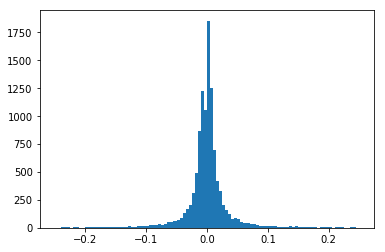

In [22]:
#lets look at the logistic regression weights of the words
#this will help us find the most important words for this predictor
print(lr_model.coef_.shape)

plt.hist(lr_model.coef_[0], range=(-0.25,0.25), bins=100)
plt.show()

In [24]:
#words associated with bad reviews 
word_index_weights = {}
threshold_high = -0.75
threshold_low = -2.5
for word, index in word_index_map.items():
    weight = lr_model.coef_[0][index]
    if (weight < threshold_high) and (weight > threshold_low):
        word_index_weights[word] = weight  
word_index_weights

{'buy': -0.87260811444875552,
 'doe': -0.99253699998345357,
 'item': -1.0661102028061813,
 'money': -1.0770486564132329,
 "n't": -2.0431091664626808,
 'poor': -0.75268197837082362,
 'return': -1.2515419823045519,
 'returned': -0.82735604309464839,
 'support': -0.90136298948655857,
 'then': -1.1133762595302299,
 'time': -0.7612825080737301,
 'wa': -1.6145258151629736,
 'waste': -0.90782401511715238}

In [175]:
#words associated with good reviews 
word_index_weights = {}
threshold_high = 2.5
threshold_low = 0.75
for word, index in word_index_map.items():
    weight = lr_model.coef_[0][index]
    if (weight < threshold_high) and (weight > threshold_low):
        word_index_weights[word] = weight  
word_index_weights

{"'ve": 0.80643305935862364,
 'easy': 1.7250249093989651,
 'excellent': 1.3019980756120713,
 'fast': 0.8537895029243654,
 'highly': 0.93623690478028387,
 'little': 0.91456846647083612,
 'lot': 0.76608939006697208,
 'love': 1.2235425113443608,
 'memory': 0.92207387502419469,
 'perfect': 0.9889968854783453,
 'quality': 1.4510523375452307,
 'sound': 1.0796126459380406,
 'speaker': 0.8651502002716569,
 'you': 0.95784972216498143}